<a href="https://colab.research.google.com/github/luisagoncalves/analise-dados-icd/blob/main/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Projeto Final de Introdução à Ciência de Dados**

### **Estudantes**
Danielle Ester Barbosa da Silva e Luísa Oliveira Gonçalves

### **Base SRAG escolhida**
Base de dados da Síndrome Respiratória Aguda Grave (SRAG), no período de 2019 a 2025.

### **Subproblema**
Diferenças regionais.

### **Objetivo**
Desenvolver uma análise exploratória e um modelo de aprendizado de máquina para compreensão dos aspectos associados às diferenças regionais de pacientes diagnosticados com COVID-19 no Brasil.

### **Coleta dos dados**
Banco de dados da Síndrome Respiratória Aguda Grave (SRAG) - 2019 a 2025
Endereço: https://opendatasus.saude.gov.br/dataset/srag-2021-a-2024
Arquivos coletados estão disponíveis no diretório ./data



In [1]:
# Libs standards
import os
import re
import warnings
import logging
from pathlib import Path
from datetime import datetime

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Machine learning - preprocessamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine learning - modelagem e pipelines
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Machine learning - métricas
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Configuração de logs e warnings
os.environ["JOBLIB_MULTIPROCESSING"] = "0"
logging.getLogger("joblib").setLevel(logging.ERROR)
logging.getLogger("loky").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")


### **Seleção das Variáveis**

As variáveis foram selecionadas mediante análise do dicionário de dados do SIVEP-Gripe, adotando critérios que se alinham ao subproblema de investigação — especificamente, a identificação de diferenças regionais nos desfechos clínicos da COVID-19.

In [2]:
VARIAVEIS = {
    # Variáveis principais
    'SG_UF': 'VARCHAR2(2)',                 # UF de residência - página 6
    'CLASSI_FIN': 'VARCHAR2(1)',            # Classificação final do caso - página 24
    'EVOLUCAO': 'VARCHAR2(1)',              # Evolução do caso - página 24
    'HOSPITAL': 'VARCHAR2(1)',              # Houve internação - página 15
    'UTI': 'VARCHAR2(1)',                   # Internado em UTI - página 16

    # 1. Dados demográficos
    'NU_IDADE_N': 'VARCHAR2(3)',            # Idade - página 4
    'TP_IDADE': 'VARCHAR2(1)',              # Tipo/Idade (Dia/Mês/Ano) - página 4
    'DT_NASC': 'DATE',                      # Data de nascimento - página 4

    # 2. Comorbidades
    'DIABETES': 'VARCHAR2(1)',              # Diabetes mellitus - página 9
    'CARDIOPATI': 'VARCHAR2(1)',            # Doença Cardiovascular Crônica - página 9
    'OBESIDADE': 'VARCHAR2(1)',             # Obesidade - página 10
    'RENAL': 'VARCHAR2(1)',                 # Doença Renal Crônica - página 10
    'PNEUMOPATI': 'VARCHAR2(1)',            # Outra Pneumopatia Crônica - página 9
    'ASMA': 'VARCHAR2(1)',                  # Asma - página 9
    'NEUROLOGIC': 'VARCHAR2(1)',            # Doença Neurológica Crônica - página 9
    'HEPATICA': 'VARCHAR2(1)',              # Doença Hepática Crônica - página 9
    'HEMATOLOGI': 'VARCHAR2(1)',            # Doença Hematológica Crônica - página 9
    'IMUNODEPRE': 'VARCHAR2(1)',            # Imunodeficiência - página 10

    # 3. Datas de sintomas e internação
    'DT_SIN_PRI': 'DATE',                   # Data de 1ºs sintomas - página 2
    'DT_INTERNA': 'DATE',                   # Data da internação por SRAG - página 16
    'DT_ENTUTI': 'DATE',                    # Data da entrada na UTI - página 16
}


DOMINIOS = {
    # Variáveis principais
    'SG_UF': {
        'tipo': 'VARCHAR2(2)',
        'descricao': 'Unidade Federativa de residência do paciente',
        'categorias': 'Siglas das UF padronizadas pelo IBGE (AC, AL, AM, AP, BA, CE, DF, ES, GO, MA, MG, MS, MT, PA, PB, PE, PI, PR, RJ, RN, RO, RR, RS, SC, SE, SP, TO)',
        'obrigatorio': 'Sim (se país for Brasil)',
    },

    'CLASSI_FIN': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Classificação final do caso (diagnóstico final)',
        'categorias': {
            '1': 'SRAG por influenza',
            '2': 'SRAG por outro vírus respiratório',
            '3': 'SRAG por outro agente etiológico',
            '4': 'SRAG não especificado',
            '5': 'SRAG por covid-19'
        },
        'obrigatorio': 'Sim',
    },

    'EVOLUCAO': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Evolução do caso',
        'categorias': {
            '1': 'Cura',
            '2': 'Óbito',
            '3': 'Óbito por outras causas',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'HOSPITAL': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Houve internação?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'UTI': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Internado em UTI?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    # 1. Dados demográficos
    'NU_IDADE_N': {
        'tipo': 'VARCHAR2(3)',
        'descricao': 'Idade informada pelo paciente ou idade aparente',
        'categorias': 'Valor numérico (idade <= 150)',
        'obrigatorio': 'Sim',
        'observacao': 'Calculado automaticamente se digitada a data de nascimento',
    },

    'TP_IDADE': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Tipo de unidade da idade',
        'categorias': {
            '1': 'Dia (0 a 30 dias)',
            '2': 'Mês (1 a 11 meses)',
            '3': 'Ano (>= 12 meses)'
        },
        'obrigatorio': 'Sim',
        'observacao': 'Calculado automaticamente baseado no intervalo entre data de nascimento e data dos primeiros sintomas',
    },

    'DT_NASC': {
        'tipo': 'DATE',
        'descricao': 'Data de nascimento do paciente',
        'categorias': 'Formato DD/MM/AAAA',
        'obrigatorio': 'Essencial',
        'validacao': 'Data deve ser <= data dos primeiros sintomas',
        'pagina': 4
    },

    # 2. Comorbidades (Fatores de risco)
    'DIABETES': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Diabetes mellitus?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'CARDIOPATI': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Cardiovascular Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'OBESIDADE': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui obesidade?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },
    'RENAL': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Renal Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'PNEUMOPATI': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui outra pneumopatia crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'ASMA': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Asma?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'NEUROLOGIC': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Neurológica Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'HEPATICA': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Hepática Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'HEMATOLOGI': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Hematológica Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'IMUNODEPRE': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Imunodeficiência ou Imunodepressão?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
        'observacao': 'Diminuição da função do sistema imunológico',
    },

    # 3. Datas de sintomas e internação
    'DT_SIN_PRI': {
        'tipo': 'DATE',
        'descricao': 'Data de 1º sintomas do caso',
        'categorias': 'Formato DD/MM/AAAA',
        'obrigatorio': 'Sim',
        'validacao': 'Data deve ser <= data da digitação e <= data do preenchimento da ficha',
    },

    'DT_INTERNA': {
        'tipo': 'DATE',
        'descricao': 'Data em que o paciente foi hospitalizado',
        'categorias': 'Formato DD/MM/AAAA',
        'obrigatorio': 'Sim',
        'validacao': 'Data deve ser >= data de 1ºs sintomas e <= data da digitação',
    },

    'DT_ENTUTI': {
        'tipo': 'DATE',
        'descricao': 'Data de entrada do paciente na Unidade de Terapia Intensiva (UTI)',
        'categorias': 'Formato DD/MM/AAAA',
        'obrigatorio': 'Essencial',
        'habilitado_se': 'Campo 53 - Internado em UTI = 1 (Sim)',
        'validacao': 'Data deve ser >= data de 1ºs sintomas e <= data da digitação',
    }
}

### **Carregamento dos dados**

O processo de carregamento dos dados foi implementado por meio de uma função que acessa os arquivos em formato CSV, correspondentes aos bancos de dados anuais do Sistema de Informação da Vigilância Epidemiológica da Gripe (SIVEP-Gripe). A função realiza:

* a leitura dos arquivos com codificação padronizada (latin1) e tratamento de linhas inconsistentes;
* a verificação da presença das variáveis predefinidas no dicionário de dados, permitindo identificar possíveis inconsistências nas bases ao longo dos anos;
* e a consolidação dos dados em um único DataFrame

In [ ]:
import gdown
from pathlib import Path
import pandas as pd

# Baixar pasta inteira
url = 'https://drive.google.com/drive/folders/16b4Gf37O3UP688kO0tBjK2KzztgFQkRM?usp=sharing'
gdown.download_folder(url, output='data', quiet=True, use_cookies=False)

def carregar_dados():
    """Carrega e consolida arquivos CSV do SIVEP-Gripe"""

    arquivos = sorted(Path('data').glob('INFLUD*.csv'))

    if not arquivos:
        print("Nenhum arquivo INFLUD*.csv encontrado na pasta 'data'")
        return None

    # Configuração de leitura
    config = {
        'sep': ';',
        'dtype': str,
        'encoding': 'latin1',
        'low_memory': False,
        'on_bad_lines': 'skip'
    }

    # Carrega e concatena todos os arquivos
    dfs = []
    for arquivo in arquivos:
        df = pd.read_csv(arquivo, **config)
        # Seleciona apenas variáveis que existem
        colunas = [v for v in VARIAVEIS if v in df.columns]
        dfs.append(df[colunas])
        print(f"✓ {arquivo.name}: {len(df):,} registros")

    df_final = pd.concat(dfs, ignore_index=True)

    # Resumo
    print(f"\nTotal: {len(df_final):,} registros | {len(df_final.columns)}/{len(VARIAVEIS)} variáveis selecionadas")

    return df_final


if __name__ == "__main__":
    df = carregar_dados()

Carregado: INFLUD19-26-06-2025.csv
- Registros: 48,961
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD20-26-06-2025.csv
- Registros: 1,206,920
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD21-26-06-2025.csv
- Registros: 1,745,672
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD22-26-06-2025.csv
- Registros: 560,577
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD23-26-06-2025.csv
- Registros: 279,453
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD24-26-06-2025.csv
- Registros: 267,984
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD25-01-12-2025.csv
- Registros: 309,502
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

RESUMO DOS DADOS:
Total de arquivos processados: 7
Total final de registros: 4,419,069

Variáveis pre

### Análise da qualidade dos dados

Realiza um diagnóstico da qualidade dos dados epidemiológicos, focando em valores nulos, validade com o domínio das variáveis e alertas para análises regionais.

Substitui valores-bandeira por NA, calcula percentuais de ausência por variável, verifica valores fora dos domínios predefinidos (ex.: UFs, códigos de evolução, vacinas), e emite alertas quando campos críticos apresentam inconsistência relevante. Além disso, lista variáveis ausentes em todos os arquivos consolidados e fornece um resumo de impacto (por exemplo: alto/moderado/baixo) para variáveis essenciais.

In [ ]:
class LimpezaSRAG:
    """
    Classe responsável pela padronização, validação e limpeza
    dos dados de SRAG para análise e modelagem.
    """

    def __init__(self, df):
        # Cria cópia do DataFrame original
        self.df = df.copy()

        # Comorbidades consideradas no estudo
        self.comorbidades = [
            'DIABETES', 'CARDIOPATI', 'OBESIDADE', 'RENAL',
            'PNEUMOPATI', 'NEUROLOGIC', 'IMUNODEPRE'
        ]

        # Unidades federativas válidas
        self.ufs_validas = [
            'AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO',
            'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR',
            'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO'
        ]

        # Colunas essenciais para análise e modelagem
        self.colunas_modelo = [
            'EVOLUCAO', 'NU_IDADE_N', 'HOSPITAL', 'UTI',
            'SG_UF'
        ] + self.comorbidades

    def limpar_dados(self):
        """
        Executa a sequência completa de limpeza dos dados.
        """
        self._padronizar()
        self._converter_tipos()
        self._filtrar_dominios()
        self._tratar_ignorados()
        self._remover_invalidos()
        self._remover_nulos()

        return self.df

    def _padronizar(self):
        # Padroniza valores ausentes para NaN
        self.df.replace(
            ['', ' ', 'NA', 'N/A', 'null', 'NULL', 'None', '-', 'nan'],
            np.nan,
            inplace=True
        )

        # Normaliza códigos de UF
        if 'SG_UF' in self.df.columns:
            self.df['SG_UF'] = (
                self.df['SG_UF']
                .astype(str)
                .str.strip()
                .str.upper()
            )

        # Remove sufixos e espaços de colunas relevantes
        for col in self.colunas_modelo:
            if col in self.df.columns:
                self.df[col] = (
                    self.df[col]
                    .astype(str)
                    .str.replace('.0', '', regex=False)
                    .str.strip()
                )

    def _converter_tipos(self):
        # Converte idade para tipo numérico
        if 'NU_IDADE_N' in self.df.columns:
            self.df['NU_IDADE_N'] = pd.to_numeric(
                self.df['NU_IDADE_N'], errors='coerce'
            )

    def _filtrar_dominios(self):
        # Mantém apenas evolução conhecida (cura ou óbito)
        self.df = self.df[
            self.df['EVOLUCAO'].isin(['1', '2'])
        ]

        # Remove registros com UF inválida
        self.df = self.df[
            self.df['SG_UF'].isin(self.ufs_validas)
        ]

        # Filtra idades fora do intervalo plausível
        self.df = self.df[
            (self.df['NU_IDADE_N'] >= 0) &
            (self.df['NU_IDADE_N'] <= 120)
        ]

    def _tratar_ignorados(self):
        # Converte códigos "ignorado" em valores ausentes
        campos_ignorado = ['HOSPITAL', 'UTI'] + self.comorbidades

        for col in campos_ignorado:
            if col in self.df.columns:
                self.df.loc[self.df[col] == '9', col] = np.nan

    def _remover_invalidos(self):
        # Mantém apenas códigos válidos para hospitalização e UTI
        for col in ['HOSPITAL', 'UTI']:
            if col in self.df.columns:
                self.df = self.df[self.df[col].isin(['1', '2'])]

        # Mantém apenas códigos válidos para comorbidades
        for col in self.comorbidades:
            if col in self.df.columns:
                self.df = self.df[self.df[col].isin(['1', '2'])]

    def _remover_nulos(self):
        # Remove registros com valores ausentes nas colunas essenciais
        self.df = self.df[self.colunas_modelo].dropna()


# Execução principal
if __name__ == "__main__":
    limpeza = LimpezaSRAG(df)
    df_limpo = limpeza.limpar_dados()



QUALIDADE DOS DADOS

1. VARIÁVEIS ESSENCIAIS E % DE NULOS
----------------------------------------------------------------------
- SG_UF          0.0% nulos → impacto baixo
- CS_ZONA       10.1% nulos → impacto moderado
- CLASSI_FIN     3.8% nulos → impacto baixo
- EVOLUCAO       7.4% nulos → impacto baixo
- HOSPITAL       2.6% nulos → impacto baixo
- UTI           13.1% nulos → impacto moderado
- NU_IDADE_N     0.0% nulos → impacto baixo
- VACINA_COV    34.7% nulos → impacto alto
- PCR_SARS2     68.8% nulos → impacto alto

2. VALORES FORA DO DOMÍNIO
----------------------------------------------------------------------
- CLASSI_FIN   26.6% inválidos → exemplos: ['5.0', '4.0', '2.0']
- EVOLUCAO     25.6% inválidos → exemplos: ['1.0', '2.0', '9.0']
- PCR_SARS2    11.8% inválidos → exemplos: ['1.0']

3. ALERTAS PARA DIFERENÇAS REGIONAIS
----------------------------------------------------------------------
- PCR_SARS2 possui muitos valores nulos


### **Limpeza dos dados**

Função de limpeza e validação dos dados brutos: normaliza valores nulos, converte tipos, corrige idades e datas, remove registros inválidos e recodifica campos críticos — retornando o DataFrame filtrado e limpo.

Preparar o DataFrame para análise exploratória e modelagem, aplicando regras específicas do dicionário SIVEP‑Gripe (ex.: domínios das variáveis, formatos de data, limites plausíveis de idade) e remover inconsistências que podem distorcer estatísticas ou treinar modelos.

In [ ]:
def preparar_dados_para_graficos(df_limpo):
    # Mapeia UF para grandes regiões do Brasil
    mapa_regioes = {
        'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte',
        'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
        'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste',
        'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste',
        'RN': 'Nordeste', 'SE': 'Nordeste',
        'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste',
        'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
        'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
        'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
    }

    # Cria cópia para preservar o DataFrame original
    df = df_limpo.copy()

    # Cria variável de região e remove registros sem correspondência
    df['REGIAO'] = df['SG_UF'].map(mapa_regioes)
    df = df[df['REGIAO'].notna()]

    # Lista de comorbidades analisadas
    comorb_cols = [
        "DIABETES", "CARDIOPATI", "OBESIDADE",
        "RENAL", "PNEUMOPATI", "NEUROLOGIC", "IMUNODEPRE"
    ]

    # Identifica pacientes com pelo menos uma comorbidade
    df['HAS_COMORB'] = (df[comorb_cols] == '1').any(axis=1)

    # Filtra apenas pacientes com comorbidades
    df_critico = df[df['HAS_COMORB']].copy()

    return df_critico


def gerar_graficos_painel(df_critico):
    # Define estilo visual dos gráficos
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    # Regiões presentes no conjunto de dados
    regioes = sorted(df_critico['REGIAO'].unique())

    # Estruturas para armazenar estatísticas regionais
    obito_pct, cura_pct = [], []
    idade_media, idade_p25, idade_p75, idade_mediana = [], [], [], []

    # Lista de comorbidades analisadas
    comorb_cols = [
        "DIABETES", "CARDIOPATI", "OBESIDADE",
        "RENAL", "PNEUMOPATI", "NEUROLOGIC", "IMUNODEPRE"
    ]

    # Dicionário para armazenar prevalência de comorbidades por região
    comorbidades = {c: [] for c in comorb_cols}

    # Calcula métricas para cada região
    for regiao in regioes:
        grupo = df_critico[df_critico['REGIAO'] == regiao]

        # Percentual de cura e óbito
        evol = grupo['EVOLUCAO'].value_counts(normalize=True) * 100
        cura_pct.append(evol.get('1', 0))
        obito_pct.append(evol.get('2', 0))

        # Estatísticas descritivas da idade
        idade = grupo['NU_IDADE_N']
        idade_media.append(idade.mean())
        idade_mediana.append(idade.median())
        idade_p25.append(idade.quantile(0.25))
        idade_p75.append(idade.quantile(0.75))

        # Prevalência de cada comorbidade
        for c in comorb_cols:
            comorbidades[c].append((grupo[c] == '1').mean() * 100)

    # Média geral de prevalência das comorbidades
    comorb_medias = {c: np.mean(v) for c, v in comorbidades.items()}

    # Seleciona as cinco comorbidades mais frequentes
    top_5 = sorted(comorb_medias.items(), key=lambda x: x[1], reverse=True)[:5]
    top_5_cols = [c for c, _ in top_5]

    # Nomes amigáveis para exibição nos gráficos
    nome_amigavel = {
        'CARDIOPATI': 'Cardiopatia',
        'DIABETES': 'Diabetes',
        'OBESIDADE': 'Obesidade',
        'RENAL': 'Doença Renal',
        'PNEUMOPATI': 'Pneumopatia',
        'NEUROLOGIC': 'Neurológica',
        'IMUNODEPRE': 'Imunodepressão'
    }

    # DataFrame para o heatmap de prevalência
    df_comorb = pd.DataFrame(
        {nome_amigavel[c]: comorbidades[c] for c in top_5_cols},
        index=regioes
    )

    # Criação da figura principal
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle(
        'Análise Regional de Pacientes com COVID-19 e Comorbidades',
        fontsize=16, fontweight='bold'
    )

    # Heatmap de prevalência das principais comorbidades por região
    ax = plt.subplot(2, 3, 2)
    sns.heatmap(
        df_comorb.T,
        annot=True,
        fmt='.1f',
        cmap='YlOrRd',
        linewidths=1,
        linecolor='gray',
        cbar_kws={'label': 'Prevalência (%)'},
        ax=ax
    )

    ax.set_xlabel('Região')
    ax.set_ylabel('Comorbidade')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Ajusta layout e salva a figura
    plt.tight_layout()
    plt.savefig(
        'analise_regional_covid_grave.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

    return fig


# Execução principal
if __name__ == "__main__":
    df_critico = preparar_dados_para_graficos(df_limpo)
    fig = gerar_graficos_painel(df_critico)


- Normalizados valores categóricos.
- Removidas 191 linhas por idades impossíveis.
- Idades em dias/meses convertidas para anos.
- Nulos padronizados em CS_ZONA, UTI, VACINA_COV e HOSPITAL.
- Datas convertidas.
- Datas de nascimento irreais tratadas.
- Nulos recodificados em CLASSI_FIN e EVOLUCAO.

Total de linhas removidas: 191


### **Estatísticas descritivas**

Gerar estatísticas e resumos regionais para pacientes críticos com COVID‑19 (internados em UTI com ≥1 comorbidade), imprimindo perfis etários, desfechos (cura × óbito) e prevalência de comorbidades por região, e retornando o subconjunto filtrado (df_critico) para uso posterior em gráficos ou relatórios.

Entrada: df — DataFrame pré‑tratado (espera colunas como SG_UF, CLASSI_FIN, HOSPITAL, UTI, NU_IDADE_N, EVOLUCAO e colunas de comorbidades).

Saída: Retorna df_critico (cópia filtrada dos casos críticos).

Também imprime no console:

* Total de pacientes no grupo crítico e critérios usados.
* Para cada região: estatísticas etárias (média, mediana, P25–P75, amplitude, desvio padrão, variância, coeficiente de variação).
* Para cada região: percentual de cura e óbito.
* Para cada região: frequência (%) das principais comorbidades.

In [ ]:
def preparar_dados(df):
    # Cria cópia para evitar alterar o DataFrame original
    df = df.copy()

    # Mantém apenas registros com evolução conhecida (cura ou óbito)
    df = df[df["EVOLUCAO"].isin(["1", "2"])]

    # Variável alvo: 0 = cura, 1 = óbito
    df["OBITO"] = df["EVOLUCAO"].map({"1": 0, "2": 1})

    # Converte idade para formato numérico
    df["NU_IDADE_N"] = pd.to_numeric(df["NU_IDADE_N"], errors="coerce")

    # Mapeia UF para grandes regiões do Brasil
    mapa_regiao = {
        "AC": "Norte", "AP": "Norte", "AM": "Norte", "PA": "Norte",
        "RO": "Norte", "RR": "Norte", "TO": "Norte",
        "AL": "Nordeste", "BA": "Nordeste", "CE": "Nordeste",
        "MA": "Nordeste", "PB": "Nordeste", "PE": "Nordeste",
        "PI": "Nordeste", "RN": "Nordeste", "SE": "Nordeste",
        "DF": "Centro-Oeste", "GO": "Centro-Oeste",
        "MT": "Centro-Oeste", "MS": "Centro-Oeste",
        "ES": "Sudeste", "MG": "Sudeste", "RJ": "Sudeste", "SP": "Sudeste",
        "PR": "Sul", "RS": "Sul", "SC": "Sul"
    }

    df["REGIAO"] = df["SG_UF"].map(mapa_regiao)

    # Seleciona variáveis clínicas, demográficas e alvo
    variaveis = [
        "NU_IDADE_N", "HOSPITAL", "UTI",
        "DIABETES", "CARDIOPATI", "OBESIDADE",
        "PNEUMOPATI", "NEUROLOGIC", "RENAL",
        "IMUNODEPRE", "REGIAO", "OBITO"
    ]

    df = df[variaveis]

    # Converte variáveis binárias para formato numérico
    mapa_binario = {"1": 1, "2": 0}
    for col in df.columns:
        if col not in ["NU_IDADE_N", "REGIAO", "OBITO"]:
            df[col] = df[col].replace("9", np.nan).map(mapa_binario)

    # Remove registros com valores ausentes
    return df.dropna()


def calcular_auc_roc(df):
    # Separa variáveis explicativas e variável alvo
    X = df.drop(columns="OBITO")
    y = df["OBITO"]

    # Divide os dados preservando a proporção da classe alvo
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # Define tipos de variáveis para pré-processamento
    numericas = ["NU_IDADE_N"]
    categoricas = ["REGIAO"]
    binarias = [c for c in X.columns if c not in numericas + categoricas]

    # Padroniza numéricas, codifica categóricas e mantém binárias
    preprocessador = ColumnTransformer([
        ("num", StandardScaler(), numericas),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categoricas),
        ("bin", "passthrough", binarias)
    ])

    # Pipeline com pré-processamento e regressão logística
    pipeline = Pipeline([
        ("prep", preprocessador),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="liblinear",
            random_state=42
        ))
    ])

    # Treina o modelo
    pipeline.fit(X_train, y_train)

    # Probabilidade predita da classe positiva (óbito)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # AUC-ROC no conjunto de teste
    auc_teste = roc_auc_score(y_test, y_prob)

    # Validação cruzada para avaliar estabilidade do modelo
    cv_auc = cross_val_score(
        pipeline, X_train, y_train,
        cv=5, scoring="roc_auc", n_jobs=-1
    )

    return {
        "auc_teste": auc_teste,
        "auc_cv_media": cv_auc.mean(),
        "auc_cv_std": cv_auc.std()
    }


def executar_analise_auc(df):
    # Prepara os dados para modelagem
    df_modelo = preparar_dados(df)

    if df_modelo.empty:
        raise ValueError("Dataset vazio após a preparação.")

    # Executa a modelagem e avaliação AUC-ROC
    resultados = calcular_auc_roc(df_modelo)

    # Exibe resultados finais
    print("RESULTADOS AUC-ROC")
    print(f"AUC teste: {resultados['auc_teste']:.4f}")
    print(
        f"AUC validação cruzada: "
        f"{resultados['auc_cv_media']:.4f} ± {resultados['auc_cv_std']:.4f}"
    )

    return resultados


# Execução principal
if __name__ == "__main__":
    resultados = executar_analise_auc(df_limpo)


/tmp/ipykernel_14407/2370866871.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Norte' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df["SG_UF"].isin(ufs), "REGIAO"] = regiao



Total de pacientes no grupo crítico: 438,531
- Critérios: Covid (5) + Internado + UTI + ≥1 comorbidade


1. PERFIL ETÁRIO POR REGIÃO (GRUPO CRÍTICO)
------------------------------------------------------------------------------------------------------------------------

→ Centro-Oeste
  Média:                 63.5
  Mediana:               65.0
  P25–P75 (IQR):         (53.0 – 76.0)
  Amplitude:             110.0
  Desvio padrão:         17.1
  Variância:             290.8
  Coeficiente de variação:26.8%

→ Nordeste
  Média:                 64.3
  Mediana:               66.0
  P25–P75 (IQR):         (54.0 – 77.0)
  Amplitude:             110.0
  Desvio padrão:         17.4
  Variância:             303.0
  Coeficiente de variação:27.1%

→ Norte
  Média:                 62.5
  Mediana:               65.0
  P25–P75 (IQR):         (53.0 – 74.0)
  Amplitude:             110.0
  Desvio padrão:         16.9
  Variância:             286.3
  Coeficiente de variação:27.1%

→ Sudeste
  Média:    

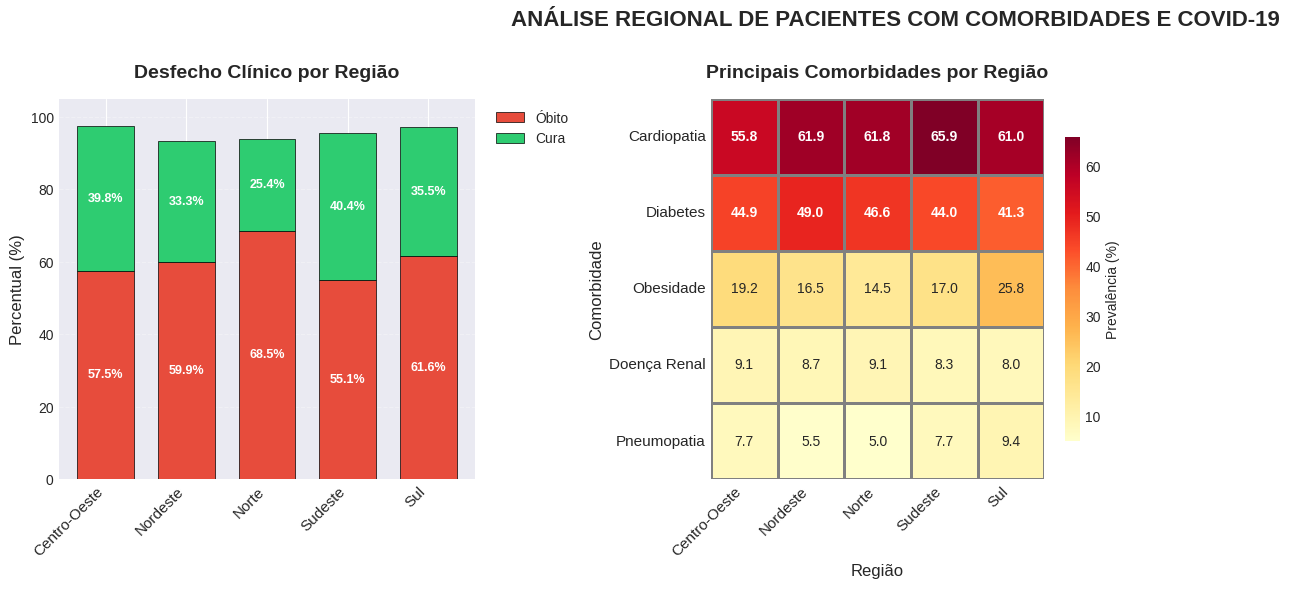

In [ ]:
def gerar_graficos_painel(df_critico):
    colunas_necessarias = ['REGIAO', 'NU_IDADE_N', 'EVOLUCAO', 'HAS_COMORB']
    comorb_cols = [
        "DIABETES", "CARDIOPATI", "OBESIDADE", "RENAL",
        "PNEUMOPATI", "ASMA", "NEUROLOGIC", "HEPATICA",
        "HEMATOLOGI", "IMUNODEPRE"
    ]

    for col in colunas_necessarias:
        if col not in df_critico.columns:
            raise ValueError(f"Coluna '{col}' não encontrada no DataFrame")

    # Configuração do estilo
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    # ============================================
    # PROCESSAR DADOS
    # ============================================

    # Lista de regiões (ordenadas)
    regioes = sorted(df_critico['REGIAO'].unique())

    # Arrays para armazenar resultados
    obito_pct = []
    cura_pct = []
    outros_pct = []

    idade_media = []
    idade_p25 = []
    idade_p75 = []
    idade_mediana = []

    # Dicionário para comorbidades
    comorbidades = {}
    for comorb in comorb_cols:
        comorbidades[comorb] = []

    # Processar cada região
    for regiao in regioes:
        grupo = df_critico[df_critico['REGIAO'] == regiao]

        # 1. Estatísticas de desfecho
        evol = grupo['EVOLUCAO'].value_counts(normalize=True) * 100
        pct_cura = evol.get("1", 0)
        pct_obito = evol.get("2", 0)
        pct_outros = 100 - (pct_cura + pct_obito)

        cura_pct.append(pct_cura)
        obito_pct.append(pct_obito)
        outros_pct.append(pct_outros)

        # 2. Estatísticas de idade
        idade = grupo['NU_IDADE_N'].dropna()
        if not idade.empty:
            idade_media.append(idade.mean())
            idade_mediana.append(idade.median())
            idade_p25.append(idade.quantile(0.25))
            idade_p75.append(idade.quantile(0.75))
        else:
            idade_media.append(0)
            idade_mediana.append(0)
            idade_p25.append(0)
            idade_p75.append(0)

        # 3. Prevalência de comorbidades
        for comorb in comorb_cols:
            if comorb in grupo.columns:
                prevalencia = (grupo[comorb] == "1").mean() * 100
                comorbidades[comorb].append(prevalencia)
            else:
                comorbidades[comorb].append(0)

    # Selecionar as 5 principais comorbidades (baseado na média)
    comorb_medias = {comorb: np.mean(vals) for comorb, vals in comorbidades.items()}
    top_5_comorb = sorted(comorb_medias.items(), key=lambda x: x[1], reverse=True)[:5]
    top_5_nomes = [nome for nome, _ in top_5_comorb]

    # Mapear nomes mais amigáveis para as comorbidades
    nome_amigavel = {
        'CARDIOPATI': 'Cardiopatia',
        'DIABETES': 'Diabetes',
        'OBESIDADE': 'Obesidade',
        'RENAL': 'Doença Renal',
        'PNEUMOPATI': 'Pneumopatia',
        'ASMA': 'Asma',
        'NEUROLOGIC': 'Neurológica',
        'HEPATICA': 'Hepática',
        'HEMATOLOGI': 'Hematológica',
        'IMUNODEPRE': 'Imunodepressão'
    }

    # Preparar dados das 5 comorbidades mais frequentes
    comorbidades_top5 = {}
    for comorb in top_5_nomes:
        nome = nome_amigavel.get(comorb, comorb)
        comorbidades_top5[nome] = comorbidades[comorb]

    # ============================================
    # CRIAR OS GRÁFICOS
    # ============================================

    fig = plt.figure(figsize=(18, 10))

    # Título geral
    n_total = f"{len(df_critico):,}".replace(",", ".")
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    fig.suptitle(
    'ANÁLISE REGIONAL DE PACIENTES COM COMORBIDADES E COVID-19\n',
    fontsize=16, fontweight='bold', x=0.5, y=0.98, ha='center'
)

    # ============================================
    # GRÁFICO 2: MAPA DE CALOR DAS COMORBIDADES
    # ============================================
    # Cria o segundo subplot na posição (2, 3, 2) - segunda posição de um grid 2x3
    ax2 = plt.subplot(2, 3, 2)

    # Prepara os dados em formato DataFrame para o heatmap
    # Linhas: regiões, Colunas: top 5 comorbidades
    df_comorb = pd.DataFrame(comorbidades_top5, index=regioes)

    # Cria o heatmap com as seguintes configurações:
    # - T: transpõe o DataFrame (comorbidades nas linhas, regiões nas colunas)
    # - annot=True: exibe os valores numéricos nas células
    # - fmt='.1f': formato com 1 casa decimal
    # - cmap='YlOrRd': esquema de cores (amarelo-laranja-vermelho)
    # - linewidths=1: largura das linhas divisórias entre células
    # - linecolor='gray': cor das linhas divisórias
    # - cbar_kws: configurações da barra de cores (rótulo e tamanho)
    # - ax=ax2: define em qual subplot será plotado
    # - annot_kws: configurações das anotações (tamanho da fonte)
    sns.heatmap(df_comorb.T, annot=True, fmt='.1f', cmap='YlOrRd',
                linewidths=1, linecolor='gray', cbar_kws={'label': 'Prevalência (%)', 'shrink': 0.8},
                ax=ax2, annot_kws={"size": 10})

    # Define o título do gráfico com formatação
    ax2.set_title(f'Principais Comorbidades por Região',
                fontsize=14, fontweight='bold', pad=15)

    # Define os rótulos dos eixos
    ax2.set_xlabel('Região', fontsize=12)
    ax2.set_ylabel('Comorbidade', fontsize=12)

    # Rotaciona os rótulos do eixo x (regiões) em 45 graus
    # ha='right': alinha horizontalmente à direita para melhor legibilidade
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=11)

    # Mantém os rótulos do eixo y (comorbidades) na horizontal
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=11)

    # Destaca visualmente células com valores altos no heatmap
    for text in ax2.texts:
        t = float(text.get_text())  # Obtém o valor numérico da célula
        if t > 50:  # Valores acima de 50%: negrito e texto branco
            text.set_fontweight('bold')
            text.set_color('white')
        elif t > 30:  # Valores entre 30% e 50%: apenas negrito
            text.set_fontweight('bold')

    plt.tight_layout()

    # Salvar figura
    plt.savefig('analise_regional_covid_grave.png', dpi=300, bbox_inches='tight', facecolor='white')

    plt.show()

    return fig

if __name__ == "__main__":
    fig = gerar_graficos_painel(df_critico)

### **Modelagem para Regressão Logística**

Utilizou regressão logística para prever o desfecho clínico de pacientes com COVID-19, categorizando-os em óbito ou cura.

Inicialmente, os dados brutos foram transformando com features, criando variáveis como faixas etárias, contagem de comorbidades, indicadores de gravidade e intervalos temporais entre eventos clínicos.  

In [ ]:
def criar_novas_informacoes(dados_limpos):
    """
    Cria novas informações a partir dos dados existentes para melhorar a previsão.

    - Transforma idade em faixas etárias
    - Conta quantas doenças a pessoa tem
    - Calcula tempo entre eventos importantes
    - Cria indicadores de gravidade
    """

    # Cópia para não alterar os dados originais
    dados_com_novas_info = dados_limpos.copy()

    print("=" * 80)
    print("INICIANDO A CRIAÇÃO DE NOVAS INFORMAÇÕES")
    print("=" * 80)

    # -------------------------------------------------------------------------
    # 1.1 DEFININDO O QUE QUEREMOS PREVER: ÓBITO (1) vs CURA (0)
    # -------------------------------------------------------------------------
    print("\n1. Criando o que vamos prever (RESULTADO_FINAL_OBITO)...")

    # Mantemos apenas casos onde sabemos o que aconteceu: 1=Cura, 2=Óbito
    dados_com_novas_info = dados_com_novas_info[dados_com_novas_info['EVOLUCAO'].isin(['1', '2'])].copy()

    # Criamos uma nova coluna: 1 se foi óbito, 0 se foi cura
    dados_com_novas_info['RESULTADO_FINAL_OBITO'] = (dados_com_novas_info['EVOLUCAO'] == '2').astype(int)

    print(f"   - Pessoas que faleceram: {dados_com_novas_info['RESULTADO_FINAL_OBITO'].sum():,}")
    print(f"   - Pessoas que se curaram: {(dados_com_novas_info['RESULTADO_FINAL_OBITO'] == 0).sum():,}")
    print(f"   - Porcentagem que faleceram: {dados_com_novas_info['RESULTADO_FINAL_OBITO'].mean()*100:.2f}%")

    # -------------------------------------------------------------------------
    # 1.2 INFORMAÇÕES SOBRE A PESSOA
    # -------------------------------------------------------------------------
    print("\n2. Analisando informações pessoais...")

    # Convertemos idade para número
    dados_com_novas_info['IDADE_NUMERO'] = pd.to_numeric(dados_com_novas_info['NU_IDADE_N'], errors='coerce')

    # Criamos grupos de idade (faixas etárias) como: crianças, adultos, idosos
    dados_com_novas_info['GRUPO_IDADE'] = pd.cut(
        dados_com_novas_info['IDADE_NUMERO'],
        bins=[0, 18, 40, 60, 80, 120],
        labels=['Criança/Adolescente (0-18)', 'Adulto Jovem (19-40)',
                'Adulto (41-60)', 'Idoso (61-80)', 'Idoso Avançado (80+)']
    )

    # Definimos em que região do Brasil a pessoa mora
    if 'REGIAO' not in dados_com_novas_info.columns:
        mapa_regioes = {
            'Norte': ['AC','AP','AM','PA','RO','RR','TO'],
            'Nordeste': ['AL','BA','CE','MA','PB','PE','PI','RN','SE'],
            'Centro-Oeste': ['DF','GO','MS','MT'],
            'Sudeste': ['ES','MG','RJ','SP'],
            'Sul': ['PR','RS','SC']
        }

        dados_com_novas_info['REGIAO'] = np.nan
        for nome_regiao, lista_estados in mapa_regioes.items():
            dados_com_novas_info.loc[dados_com_novas_info['SG_UF'].isin(lista_estados), 'REGIAO'] = nome_regiao

    # Verificamos se mora na cidade (urbano) ou no campo (rural)
    dados_com_novas_info['MORA_CIDADE'] = (dados_com_novas_info['CS_ZONA'] == '1').astype(int)

    print(f"   - Idade média: {dados_com_novas_info['IDADE_NUMERO'].mean():.1f} anos")
    print(f"   - Grupos de idade criados: {dados_com_novas_info['GRUPO_IDADE'].nunique()}")
    print(f"   - Regiões identificadas: {dados_com_novas_info['REGIAO'].nunique()}")

    # -------------------------------------------------------------------------
    # 1.3 INFORMAÇÕES SOBRE DOENÇAS EXISTENTES
    # -------------------------------------------------------------------------
    print("\n3. Contabilizando outras doenças que a pessoa já tinha...")

    # Lista de doenças que podemos verificar
    lista_doencas_existentes = [
        'DIABETES', 'CARDIOPATI', 'OBESIDADE', 'RENAL',
        'PNEUMOPATI', 'ASMA', 'NEUROLOGIC', 'HEPATICA',
        'HEMATOLOGI', 'IMUNODEPRE'
    ]

    # Para cada doença, marcamos 1 se a pessoa tinha, 0 se não tinha
    for doenca in lista_doencas_existentes:
        if doenca in dados_com_novas_info.columns:
            dados_com_novas_info[f'{doenca}_BINARIO'] = (dados_com_novas_info[doenca] == '1').astype(int)

    # Contamos quantas doenças a pessoa tinha no total
    colunas_doencas_binarias = [f'{doenca}_BINARIO' for doenca in lista_doencas_existentes
                              if f'{doenca}_BINARIO' in dados_com_novas_info.columns]
    dados_com_novas_info['TOTAL_DOENCAS_EXISTENTES'] = dados_com_novas_info[colunas_doencas_binarias].sum(axis=1)

    # Criamos grupos de risco baseado no número de doenças
    dados_com_novas_info['NIVEL_RISCO'] = pd.cut(
        dados_com_novas_info['TOTAL_DOENCAS_EXISTENTES'],
        bins=[-1, 0, 1, 2, 10],
        labels=['Sem outras doenças', '1 doença prévia', '2 doenças prévias', '3+ doenças prévias']
    )

    print(f"   - Média de doenças prévias: {dados_com_novas_info['TOTAL_DOENCAS_EXISTENTES'].mean():.2f}")
    print(f"   - Distribuição por nível de risco:")
    print(dados_com_novas_info['NIVEL_RISCO'].value_counts().to_string())

    # -------------------------------------------------------------------------
    # 1.4 INFORMAÇÕES SOBRE TEMPO ENTRE EVENTOS
    # -------------------------------------------------------------------------
    print("\n4. Calculando tempos importantes...")

    # Convertemos datas de texto para formato de data
    for coluna_data in ['DT_SIN_PRI', 'DT_INTERNA', 'DT_ENTUTI']:
        if coluna_data in dados_com_novas_info.columns:
            dados_com_novas_info[coluna_data] = pd.to_datetime(dados_com_novas_info[coluna_data], errors='coerce')

    # Calculamos quanto tempo passou entre sintomas e internação
    if 'DT_SIN_PRI' in dados_com_novas_info.columns and 'DT_INTERNA' in dados_com_novas_info.columns:
        dados_com_novas_info['DIAS_SINTOMAS_ATE_INTERNACAO'] = (dados_com_novas_info['DT_INTERNA'] - dados_com_novas_info['DT_SIN_PRI']).dt.days

        # Corrigimos valores extremos (menos de 0 dias ou mais de 1 ano)
        dados_com_novas_info['DIAS_SINTOMAS_ATE_INTERNACAO'] = dados_com_novas_info['DIAS_SINTOMAS_ATE_INTERNACAO'].clip(lower=0, upper=365)

        print(f"   - Tempo médio sintomas→internação: {dados_com_novas_info['DIAS_SINTOMAS_ATE_INTERNACAO'].mean():.1f} dias")

    # Calculamos quanto tempo passou entre internação e entrada na UTI
    if 'DT_INTERNA' in dados_com_novas_info.columns and 'DT_ENTUTI' in dados_com_novas_info.columns:
        dados_com_novas_info['DIAS_INTERNACAO_ATE_UTI'] = (dados_com_novas_info['DT_ENTUTI'] - dados_com_novas_info['DT_INTERNA']).dt.days
        dados_com_novas_info['DIAS_INTERNACAO_ATE_UTI'] = dados_com_novas_info['DIAS_INTERNACAO_ATE_UTI'].clip(lower=0, upper=365)

        print(f"   - Tempo médio internação→UTI: {dados_com_novas_info['DIAS_INTERNACAO_ATE_UTI'].mean():.1f} dias")

    # -------------------------------------------------------------------------
    # 1.5 INFORMAÇÕES SOBRE VACINAÇÃO
    # -------------------------------------------------------------------------
    print("\n5. Verificando situação vacinal...")

    # Marca se a pessoa foi vacinada (1) ou não (0)
    dados_com_novas_info['RECEBEU_VACINA'] = (dados_com_novas_info['VACINA_COV'] == '1').astype(int)

    # Contamos quantas doses a pessoa recebeu
    colunas_doses = ['DOSE_1_COV', 'DOSE_2_COV', 'DOSE_REF', 'DOSE_2REF', 'DOSE_ADIC', 'DOS_RE_BI']
    dados_com_novas_info['TOTAL_DOSES'] = 0

    for coluna_dose in colunas_doses:
        if coluna_dose in dados_com_novas_info.columns:
            # Convertemos para data e contamos se tem data válida
            dados_com_novas_info[coluna_dose] = pd.to_datetime(dados_com_novas_info[coluna_dose], errors='coerce')
            dados_com_novas_info['TOTAL_DOSES'] += dados_com_novas_info[coluna_dose].notna().astype(int)

    print(f"   - Porcentagem vacinada: {dados_com_novas_info['RECEBEU_VACINA'].mean()*100:.1f}%")
    print(f"   - Distribuição por número de doses:")
    print(dados_com_novas_info['TOTAL_DOSES'].value_counts().sort_index().to_string())

    # -------------------------------------------------------------------------
    # 1.6 CRIANDO UM INDICADOR DE GRAVIDADE
    # -------------------------------------------------------------------------
    print("\n6. Criando um indicador de quão grave foi o caso...")

    # Marca se a pessoa foi para UTI
    dados_com_novas_info['FOI_PARA_UTI'] = (dados_com_novas_info['UTI'] == '1').astype(int)

    # Marca se a pessoa foi hospitalizada
    dados_com_novas_info['FOI_HOSPITALIZADA'] = (dados_com_novas_info['HOSPITAL'] == '1').astype(int)

    # Criamos um "score" de gravidade (quanto maior, mais grave)
    # Pontuação: UTI=3 pontos, Hospitalizado=2 pontos, Idade>=60=1 ponto, 3+ doenças prévias=2 pontos
    dados_com_novas_info['SCORE_GRAVIDADE'] = (
        dados_com_novas_info['FOI_PARA_UTI'] * 3 +
        dados_com_novas_info['FOI_HOSPITALIZADA'] * 2 +
        (dados_com_novas_info['IDADE_NUMERO'] >= 60).astype(int) +
        (dados_com_novas_info['TOTAL_DOENCAS_EXISTENTES'] >= 3).astype(int) * 2
    )

    print(f"   - Porcentagem que foi para UTI: {dados_com_novas_info['FOI_PARA_UTI'].mean()*100:.1f}%")
    print(f"   - Score de gravidade médio: {dados_com_novas_info['SCORE_GRAVIDADE'].mean():.2f}")

    print("\n" + "=" * 80)
    print("CRIAÇÃO DE NOVAS INFORMAÇÕES CONCLUÍDA")
    print("=" * 80)

    return dados_com_novas_info


# ==============================================================================
# 2. PREPARANDO OS DADOS PARA O APRENDIZADO DE MÁQUINA
# ==============================================================================

def preparar_dados_para_aprendizado(dados_com_todas_info):
    """
    Prepara os dados para a máquina conseguir entender e aprender:
    - Escolhe as informações mais importantes
    - Remove dados faltantes
    - Transforma categorias em números
    - Separa o que queremos prever das informações que usamos para prever
    """

    print("\n" + "=" * 80)
    print("PREPARANDO DADOS PARA O APRENDUZADO DE MÁQUINA")
    print("=" * 80)

    dados = dados_com_todas_info.copy()

    # -------------------------------------------------------------------------
    # 2.1 ESCOLHENDO AS INFORMAÇÕES MAIS IMPORTANTES
    # -------------------------------------------------------------------------
    print("\n1. Selecionando as informações mais relevantes...")

    # Informações numéricas (números)
    informacoes_numericas = [
        'IDADE_NUMERO',
        'TOTAL_DOENCAS_EXISTENTES',
        'TOTAL_DOSES',
        'SCORE_GRAVIDADE',
        'DIAS_SINTOMAS_ATE_INTERNACAO',
        'DIAS_INTERNACAO_ATE_UTI'
    ]

    # Informações de sim/não (binárias)
    informacoes_sim_nao = [
        'RECEBEU_VACINA',
        'FOI_PARA_UTI',
        'FOI_HOSPITALIZADA',
        'MORA_CIDADE'
    ]

    # Doenças específicas (cada uma como sim/não)
    informacoes_doencas_especificas = [
        'DIABETES_BINARIO', 'CARDIOPATI_BINARIO', 'OBESIDADE_BINARIO',
        'RENAL_BINARIO', 'PNEUMOPATI_BINARIO'
    ]

    # Informações de categorias (como região, faixa etária)
    informacoes_categorias = ['REGIAO', 'GRUPO_IDADE', 'NIVEL_RISCO']

    # Juntamos todas as informações selecionadas
    todas_informacoes_selecionadas = (
        informacoes_numericas +
        informacoes_sim_nao +
        informacoes_doencas_especificas +
        informacoes_categorias
    )

    # Mantemos apenas as informações que realmente existem nos dados
    informacoes_disponiveis = [info for info in todas_informacoes_selecionadas if info in dados.columns]

    print(f"   - Informações selecionadas: {len(informacoes_disponiveis)}")

    # -------------------------------------------------------------------------
    # 2.2 LIDANDO COM DADOS FALTANTES
    # -------------------------------------------------------------------------
    print("\n2. Tratando dados que estão faltando...")

    # Criamos um novo conjunto só com as informações selecionadas e o resultado final
    dados_para_modelo = dados[informacoes_disponiveis + ['RESULTADO_FINAL_OBITO']].copy()

    print(f"   - Registros antes do tratamento: {len(dados_para_modelo):,}")

    # Para informações numéricas faltantes, usamos o valor do meio (mediana)
    for coluna_num in informacoes_numericas:
        if coluna_num in dados_para_modelo.columns:
            valor_do_meio = dados_para_modelo[coluna_num].median()
            dados_para_modelo[coluna_num].fillna(valor_do_meio, inplace=True)

    # Removemos linhas onde faltam informações de categorias
    dados_para_modelo = dados_para_modelo.dropna(subset=informacoes_categorias)

    print(f"   - Registros depois do tratamento: {len(dados_para_modelo):,}")
    print(f"   - Registros removidos: {len(dados) - len(dados_para_modelo):,}")

    # -------------------------------------------------------------------------
    # 2.3 TRANSFORMANDO CATEGORIAS EM NÚMEROS
    # -------------------------------------------------------------------------
    print("\n3. Transformando categorias em números que a máquina entende...")

    # "One-hot encoding": cria uma coluna separada para cada categoria
    # Exemplo: Região "Norte" vira coluna REGIAO_Norte com valor 1 (sim) ou 0 (não)
    dados_transformados = pd.get_dummies(
        dados_para_modelo,
        columns=informacoes_categorias,
        drop_first=True  # Evita criar colunas desnecessárias
    )

    print(f"   - Dimensão após transformação: {dados_transformados.shape}")

    # -------------------------------------------------------------------------
    # 2.4 SEPARANDO O QUE QUEREMOS PREVER DAS INFORMAÇÕES QUE USAMOS
    # -------------------------------------------------------------------------
    print("\n4. Separando o alvo (o que queremos prever) dos dados de entrada...")

    # O que queremos prever: se a pessoa faleceu (1) ou se curou (0)
    alvo_previsao = dados_transformados['RESULTADO_FINAL_OBITO']

    # As informações que usamos para fazer a previsão
    dados_para_prever = dados_transformados.drop('RESULTADO_FINAL_OBITO', axis=1)

    print(f"   - Formato dos dados de entrada: {dados_para_prever.shape}")
    print(f"   - Formato do alvo: {alvo_previsao.shape}")
    print(f"   - Porcentagem de óbitos no total: {alvo_previsao.mean()*100:.2f}%")

    print("\n" + "=" * 80)
    print("PREPARAÇÃO DOS DADOS CONCLUÍDA")
    print("=" * 80)

    return dados_para_prever, alvo_previsao, dados_transformados


# ==============================================================================
# 3. DIVIDINDO EM TREINO/TESTE E AJUSTANDO A ESCALA
# ==============================================================================

def dividir_e_ajustar_escala(dados_entrada, alvo, tamanho_teste=0.3, semente_aleatoria=42):
    """
    Divide os dados em dois grupos: para treinar a máquina e para testar o que ela aprendeu.
    Também ajusta a escala das informações para que todas tenham o mesmo "peso".

    Por que 70% treino e 30% teste?
    - 70% para treino: A MÁQUINA precisa de bastante exemplos para aprender bem
    - 30% para teste: precisamos verificar se ele realmente aprendeu, não apenas decorou
    """

    print("\n" + "=" * 80)
    print("DIVIDINDO DADOS E AJUSTANDO ESCALAS")
    print("=" * 80)

    # -------------------------------------------------------------------------
    # 3.1 DIVIDINDO OS DADOS
    # -------------------------------------------------------------------------
    porcentagem_treino = int((1-tamanho_teste)*100)
    porcentagem_teste = int(tamanho_teste*100)
    print(f"\n1. Dividindo os dados (treino: {porcentagem_treino}%, teste: {porcentagem_teste}%)...")

    # Dividimos mantendo a mesma proporção de óbitos em ambos os grupos
    dados_entrada_treino, dados_entrada_teste, alvo_treino, alvo_teste = train_test_split(
        dados_entrada, alvo,
        test_size=tamanho_teste,
        random_state=semente_aleatoria,
        stratify=alvo  # Mantém a mesma proporção de óbitos em treino e teste
    )

    print(f"   - Dados de treino: {len(dados_entrada_treino):,} registros ({len(dados_entrada_treino)/len(dados_entrada)*100:.1f}%)")
    print(f"   - Dados de teste: {len(dados_entrada_teste):,} registros ({len(dados_entrada_teste)/len(dados_entrada)*100:.1f}%)")
    print(f"\n   - Porcentagem óbitos (treino): {alvo_treino.mean()*100:.2f}%")
    print(f"   - Porcentagem óbitos (teste): {alvo_teste.mean()*100:.2f}%")

    # -------------------------------------------------------------------------
    # 3.2 AJUSTANDO A ESCALA DAS INFORMAÇÕES
    # -------------------------------------------------------------------------
    print("\n2. Ajustando a escala das informações...")
    print("   Por que ajustar a escala?")
    print("   - Para comparar idade (0-100) com número de doses (0-5)")
    print("   - Sem ajuste, a idade pareceria muito mais importante só porque tem números maiores")
    print("   - Ajustando a escala, damos peso igual a todas as informações")

    # Criamos um "ajustador de escala"
    ajustador_escala = StandardScaler()

    # Ajustamos a escala usando APENAS os dados de treino
    # (Isso é importante para não "roubar" informação dos dados de teste)
    dados_entrada_treino_escala_ajustada = ajustador_escala.fit_transform(dados_entrada_treino)
    dados_entrada_teste_escala_ajustada = ajustador_escala.transform(dados_entrada_teste)

    # Convertemos de volta para tabela (mantendo os nomes das colunas)
    dados_entrada_treino_escala_ajustada = pd.DataFrame(
        dados_entrada_treino_escala_ajustada,
        columns=dados_entrada_treino.columns,
        index=dados_entrada_treino.index
    )

    dados_entrada_teste_escala_ajustada = pd.DataFrame(
        dados_entrada_teste_escala_ajustada,
        columns=dados_entrada_teste.columns,
        index=dados_entrada_teste.index
    )

    print(f"   - Informações com escala ajustada: {dados_entrada_treino_escala_ajustada.shape[1]}")

    print("\n" + "=" * 80)
    print("DADOS PRONTOS PARA O APRENDUZADO DE MÁQUINA")
    print("=" * 80)

    return dados_entrada_treino_escala_ajustada, dados_entrada_teste_escala_ajustada, alvo_treino, alvo_teste, ajustador_escala


# ==============================================================================
# 4. ENSINANDO A MÁQUINA A PREVER
# ==============================================================================

def ensinar_maquina_a_prever(dados_treino, alvo_treino, dados_teste, alvo_teste):
    """
    Ensina a máquina a prever óbitos usando Regressão Logística.
    Mostramos exemplos (treino) e depois testamos se aprendeu (teste).
    """

    print("\n" + "=" * 80)
    print("ENSINANDO A MÁQUINA A PREVER (REGRESSÃO LOGÍSTICA)")
    print("=" * 80)

    # -------------------------------------------------------------------------
    # 4.1 ENSINANDO A MÁQUINA
    # -------------------------------------------------------------------------
    print("\n1. Ensinando a máquina com os dados de treino...")

    # Criamos um modelo vazio para a máquina
    modelo_maquina = LogisticRegression(
        max_iter=1000,           # Damos tempo suficiente para aprender
        random_state=42,         # Usamos mesma "semente" para resultados consistentes
        class_weight='balanced', # Damos mais atenção aos casos raros (óbitos)
        solver='lbfgs'           # Usamos método eficiente de aprendizado
    )

    # Ensinamos a máquina com os dados de treino
    modelo_maquina.fit(dados_treino, alvo_treino)

    print("Máquina treinada")

    # -------------------------------------------------------------------------
    # 4.2 TESTANDO O APRENDIZADO DA MÁQUINA
    # -------------------------------------------------------------------------
    print("\n2. Testando o aprendizado...")

    # Prevendo os resultados
    previsoes_treino = modelo_maquina.predict(dados_treino)
    previsoes_teste = modelo_maquina.predict(dados_teste)

    # Medindo a confiança de cada previsão (probabilidade)
    probabilidades_treino = modelo_maquina.predict_proba(dados_treino)[:, 1]
    probabilidades_teste = modelo_maquina.predict_proba(dados_teste)[:, 1]

    # -------------------------------------------------------------------------
    # 4.3 AVALIANDO O DESEMPENHO DA MÁQUINA
    # -------------------------------------------------------------------------
    print("\n3. Avaliando o desempenhO...")

    print("\n" + "-" * 80)
    print("DESEMPENHO NOS DADOS DE TREINO (O QUE FOI AVALIADO DURANTE O TREINO)")
    print("-" * 80)

    # Acurácia: porcentagem de acertos totais
    acuracia_treino = accuracy_score(alvo_treino, previsoes_treino)
    print(f"\nAcurácia (acertos totais): {acuracia_treino:.4f} ({acuracia_treino*100:.2f}%)")

    # Precisão, Recall e F1: diferentes formas de medir acertos
    precisao, recall, f1, _ = precision_recall_fscore_support(
        alvo_treino, previsoes_treino, average='binary'
    )

    print(f"Precisão (quando diz que é óbito, acerta): {precisao:.4f}")
    print(f"Recall (consegue identificar os óbitos): {recall:.4f}")
    print(f"F1-Score (média balanceada): {f1:.4f}")

    # AUC-ROC: mede a capacidade geral de distinguir óbitos de curas
    auc_treino = roc_auc_score(alvo_treino, probabilidades_treino)
    print(f"AUC-ROC (capacidade de distinguir): {auc_treino:.4f}")

    # Matriz de Confusão: mostra onde a máquina acerta e erra
    print("\nMatriz de Confusão (o que preveu vs o que realmente aconteceu):")
    matriz_confusao_treino = confusion_matrix(alvo_treino, previsoes_treino)
    print(matriz_confusao_treino)
    print("Legenda:")
    print("  [Cura prevista corretamente]  [Cura prevista como óbito (erro)]")
    print("  [Óbito previsto como cura (erro)]  [Óbito previsto corretamente]")

    print("\n" + "-" * 80)
    print("DESEMPENHO NOS DADOS DE TESTE (O QUE É NOVO PARA A MÁQUINA)")
    print("-" * 80)

    # As mesmas métricas, mas agora nos dados de teste
    acuracia_teste = accuracy_score(alvo_teste, previsoes_teste)
    print(f"\nAcurácia (acertos totais): {acuracia_teste:.4f} ({acuracia_teste*100:.2f}%)")

    precisao, recall, f1, _ = precision_recall_fscore_support(
        alvo_teste, previsoes_teste, average='binary'
    )

    print(f"Precisão (quando diz que é óbito, acerta): {precisao:.4f}")
    print(f"Recall (consegue identificar os óbitos): {recall:.4f}")
    print(f"F1-Score (média balanceada): {f1:.4f}")

    auc_teste = roc_auc_score(alvo_teste, probabilidades_teste)
    print(f"AUC-ROC (capacidade de distinguir): {auc_teste:.4f}")

    print("\nMatriz de Confusão (o que preveu vs o que realmente aconteceu):")
    matriz_confusao_teste = confusion_matrix(alvo_teste, previsoes_teste)
    print(matriz_confusao_teste)

    print("\n" + "-" * 80)
    print("RELATÓRIO COMPLETO DE DESEMPENHO (TESTE)")
    print("-" * 80)
    print(classification_report(alvo_teste, previsoes_teste, target_names=['Cura', 'Óbito']))

    # -------------------------------------------------------------------------
    # 4.4 ENTENDENDO O QUE A MÁQUINA APRENDEU
    # -------------------------------------------------------------------------
    print("\n" + "-" * 80)
    print("AS INFORMAÇÕES MAIS IMPORTANTES QUE A MÁQUINA APRENDEU")
    print("-" * 80)

    # A máquina aprendeu "pesos" para cada informação
    # Peso positivo: aumenta a chance de óbito
    # Peso negativo: diminui a chance de óbito
    pesos_aprendidos = pd.DataFrame({
        'Informação': dados_treino.columns,
        'Peso_Aprendido': modelo_maquina.coef_[0]
    })

    # Calculamos a importância (valor absoluto do peso)
    pesos_aprendidos['Importancia_Absoluta'] = np.abs(pesos_aprendidos['Peso_Aprendido'])
    pesos_aprendidos = pesos_aprendidos.sort_values('Importancia_Absoluta', ascending=False)

    print("\n(Pesos positivos aumentam risco de óbito, negativos diminuem)")
    print(pesos_aprendidos.head(10).to_string(index=False))

    print("\n" + "=" * 80)
    print("PROCESSO DE APRENDIZADO CONCLUÍDO")
    print("=" * 80)

    resultado_aprendizado = {
        'modelo_maquina': modelo_maquina,
        'desempenho_treino': {
            'acuracia': acuracia_treino,
            'auc_roc': auc_treino
        },
        'desempenho_teste': {
            'acuracia': acuracia_teste,
            'precisao': precisao,
            'recall': recall,
            'f1_score': f1,
            'auc_roc': auc_teste
        },
        'matriz_confusao': matriz_confusao_teste,
        'pesos_aprendidos': pesos_aprendidos
    }

    return resultado_aprendizado


def executar_processo_completo_aprendizado(dados_limpos):
    """
    Executa todo o processo de aprendizado de máquina:
    1. Cria novas informações úteis
    2. Prepara os dados
    3. Divide em treino e teste
    4. Ensina a máquina
    5. Avalia o que foi aprendido
    """

    print("\n" + "=" * 80)
    print("INICIANDO APRENDIZADO DE MÁQUINA")
    print("=" * 80)

    # 1. Criamos novas informações a partir dos dados
    dados_com_todas_info = criar_novas_informacoes(dados_limpos)

    # 2. Preparamos os dados para a máquina entender
    dados_entrada, alvo_previsao, dados_transformados = preparar_dados_para_aprendizado(dados_com_todas_info)

    # 3. Dividimos em dados para treinar e dados para testar
    dados_treino, dados_teste, alvo_treino, alvo_teste, ajustador_escala = dividir_e_ajustar_escala(dados_entrada, alvo_previsao)

    # 4. Ensinamos a máquina e avaliamos o aprendizado
    resultado_aprendizado = ensinar_maquina_a_prever(dados_treino, alvo_treino, dados_teste, alvo_teste)

    print("\n" + "=" * 80)
    print("PROCESSO COMPLETO CONCLUÍDO COM SUCESSO!")
    print("=" * 80)

    # Retornamos tudo o que foi feito
    return {
        'dados_com_todas_info': dados_com_todas_info,
        'dados_treino': dados_treino,
        'dados_teste': dados_teste,
        'alvo_treino': alvo_treino,
        'alvo_teste': alvo_teste,
        'ajustador_escala': ajustador_escala,
        'resultado_aprendizado': resultado_aprendizado
    }

if __name__ == "__main__":
    resultado_final = executar_processo_completo_aprendizado(df_tratado)

    maquina_treinada = resultado_final['resultado_aprendizado']['modelo_maquina']
    metricas_finais = resultado_final['resultado_aprendizado']['desempenho_teste']


INICIANDO APRENDIZADO DE MÁQUINA
INICIANDO A CRIAÇÃO DE NOVAS INFORMAÇÕES

1. Criando o que vamos prever (RESULTADO_FINAL_OBITO)...
   - Pessoas que faleceram: 922,588
   - Pessoas que se curaram: 2,990,897
   - Porcentagem que faleceram: 23.57%

2. Analisando informações pessoais...


/tmp/ipykernel_14407/1486457593.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Norte' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dados_com_novas_info.loc[dados_com_novas_info['SG_UF'].isin(lista_estados), 'REGIAO'] = nome_regiao


   - Idade média: 48.5 anos
   - Grupos de idade criados: 5
   - Regiões identificadas: 5

3. Contabilizando outras doenças que a pessoa já tinha...
   - Média de doenças prévias: 0.70
   - Distribuição por nível de risco:
NIVEL_RISCO
Sem outras doenças    2132345
1 doença prévia       1056495
2 doenças prévias      535058
3+ doenças prévias     189587

4. Calculando tempos importantes...
   - Tempo médio sintomas→internação: 5.9 dias
   - Tempo médio internação→UTI: 1.2 dias

5. Verificando situação vacinal...
   - Porcentagem vacinada: 28.1%
   - Distribuição por número de doses:
TOTAL_DOSES
0    2902986
1     191570
2     451086
3     217855
4     102405
5      46744
6        839

6. Criando um indicador de quão grave foi o caso...
   - Porcentagem que foi para UTI: 28.9%
   - Score de gravidade médio: 3.31

CRIAÇÃO DE NOVAS INFORMAÇÕES CONCLUÍDA

PREPARANDO DADOS PARA O APRENDUZADO DE MÁQUINA

1. Selecionando as informações mais relevantes...
   - Informações selecionadas: 18

2. T